### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 100 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.2
COMMUNICATION_SPEED = 0.1
TOTAL_TIME = 60
V_MAX = 40
GLOBAL_TIME_WINDOW = 100  # Strategic Phaseでの時間幅
DENSITY = 4.0 # 車がminimumで何秒に1回くるか. 
TTC = 2.5 #車間時間を暫定的に定義

def generate_arrival_times(car_num, DENSITY):
    sequence = [random.uniform(0, 5)]
    while len(sequence) < car_num:
        next_value = sequence[-1] + DENSITY + random.uniform(0, 3)
        sequence.append(next_value)
    return sequence

arrival_times = generate_arrival_times(CAR_NUM, TTC)


In [2]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
# arrival_times = [2.65457725264784, 5.519023868368322, 8.359514841623813, 12.650984815640962, 15.416654604044085, 20.713123114743784, 25.573249947653295, 29.113823476836664, 34.064221711207054, 37.96199764959094, 41.93319466691726, 44.56571415956607, 49.07509918348945, 53.11313937451763, 57.48319736648235, 61.86162883944515, 66.9300141894827, 71.11763196557857, 73.83862502939377, 78.36291523339247, 83.00284466638122, 87.44586073702, 92.50551132803729, 95.27853797712942, 98.98841776258791, 103.9850018280912, 107.03897894776168, 109.83935708021232, 112.42192623262706, 116.77303621589067, 120.31051814369201, 123.54315524537894, 126.9961705372461, 132.46163211312253, 137.88111028775876, 142.71381215313974, 146.09747365994275, 151.49362622526954, 154.31156100812927, 157.39954600958302, 161.89359521296242, 165.45623220847378, 169.4997553518809, 172.18785807186893, 177.6797115847411, 182.91949433990834, 186.75351142083247, 192.04968462842996, 197.36337709516764, 201.11482881321658, 204.58063685053938, 207.84159927784762, 213.09736516898275, 215.73077339555545, 221.03524108292885, 225.97508462856925, 228.50920175604435, 233.26184887560734, 237.7726042662581, 241.77878409221583, 247.08343208009873, 251.30460954807896, 255.32271786767691, 258.1214051549246, 262.60861809272535, 266.38952283477647, 269.8529538509632, 274.3035685172973, 277.64390325626016, 280.49338204352426, 283.9969794661729, 287.11016341049145, 289.7597903809903, 293.8136034180251, 297.55439066880143, 300.54510706382285, 304.15244945918863, 307.3148867050638, 311.9049208744112, 316.4629338933939, 319.6696693949085, 323.1304730518358, 327.46113300034636, 332.52810718178335, 335.0420810615189, 339.72911356996366, 343.3261865450523, 346.26746483979866, 349.76611919193095, 353.9736541738109, 358.55321670933023, 361.4259636691283, 366.7778449550154, 371.90346124626427, 375.6475606482963, 379.74309239490333, 383.98827383513327, 388.02155171460697, 391.388847055334, 394.17650624101344]
# arrival_times = [1, 4, 9, 15, 18, 20.6, 25, 48.18130400339028, 52.51443649098328, 57.58770193570899, 60.1]
print(arrival_times)
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

[0.8860144570371781, 4.177514858044501, 7.934155817575771, 10.555277296022657, 13.252344207322153, 16.180787710546042, 19.689087054274598, 23.760106169317574, 26.480004546606626, 30.49232045405554, 33.98719602221633, 37.00045061544265, 41.2902528472509, 43.96019903350773, 48.00546931640106, 50.613293142169304, 55.93715389797011, 61.141855919818084, 65.37139039979384, 68.24847862584726, 71.97250638454125, 76.26426940594791, 79.45419560403042, 82.8283544821783, 85.90297073403916, 89.60770684893376, 92.18747635130796, 97.50708365277379, 101.01621025549498, 104.8069732426226, 110.13290073392498, 113.3032616162055, 117.77757238029318, 120.68943046008759, 125.96064104794546, 128.88326676962743, 132.78557051345138, 138.23245513177972, 142.7833933544908, 147.70950106908427, 152.2838571575723, 156.88657595401943, 159.67370742231037, 163.76721753261748, 168.6615734082196, 173.3383187805578, 178.34289648911604, 181.51828091830444, 185.5365093808681, 189.4941116548791, 192.53157482924865, 197.6282

In [3]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = reservation_table.validate(desired_eta_list)
    if is_valid:
        reservation_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        reservation_table.register(calibrated_list)
        car.my_list = calibrated_list

### シミュレーションの流れ

各時刻において以下の計算を行う
1. ノイズ発生フェーズ: ある時刻にもしノイズがなければ一定確率で発生させる
2. 情報更新フェーズ

   ノイズ発生フェーズで生じたノイズと、直前の時刻での情報更新に基づいて影響を受ける車を列挙.
   
   `reactive_cars`に格納
4. `reactive_cars`の先頭車がノイズに反応(処理としては`cars.react_to_noise()`).

   `cwp_table`を書き換える
6. 今の状態で一歩前進

In [4]:
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
simulation.conduct_simulation(should_plot=True)

Simulation Progress:   0%|          | 0/300 [00:00<?, ?it/s]

noise created!

t=1.0, next_car=1, current_noise= [{'x': [610, 730], 't': [40, 50]}], event_flg=arrival
carID: 0, Start:780.0, End:980.0
======update by ID:0!=======
直接ノイズの影響を受けるもの: []
他の車の影響: []
対象車: []

t=4.2, next_car=2, current_noise= [{'x': [610, 730], 't': [40, 50]}], event_flg=arrival
carID: 0, Start:780.0, End:980.0
carID: 1, Start:716.0, End:916.0
======update by ID:0!=======
======update by ID:1!=======
直接ノイズの影響を受けるもの: [1]
他の車の影響: []
対象車: [1]
car_id:1 avoiding noise.
avoidance by idx=1
{'x': [610, 730], 't': [40, 50]} True
35.8 3 30
eta: 39.98601445703718, 最速:39.88601445703718, 刻限:40
solve_acc_itinerary_early_avoid
ループ抜ける判定基準2: [False, False, False, True, True, True, True, True, True, True]
detail:  [{'eta': 3.386014457037178, 'arrival_time': 4.2, 'x': 0.0}, {'eta': 8.386014457037177, 'arrival_time': 8.851162790697675, 'x': 100.0}, {'eta': 13.386014457037177, 'arrival_time': 13.50232558139535, 'x': 200.0}, {'eta': 18.386014457037177, 'arrival_time': 18.153488372093022, 'x': 3

In [8]:
car_1 = CARS[1]
print("ETA",car_1.my_etas)
print(car_1.acc_itinerary)
print()
print(car_1.itinerary)
print()
car_2 = CARS[2]
print("ETA",car_2.my_etas)
print(car_2.acc_itinerary)
# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

ETA [{'waypoint_idx': 0, 'x': 0.0, 'eta': 3.777571637331311, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 11.05, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 19.05, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 27.05, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 35.05, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 43.05, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 51.05, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 56.961111111111116, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 60.82118644067797, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 63.89406438631791, 'car_idx': 1, 'type': 'waypoint'}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 66.51898633904284, 'car_idx': 1, 'type': 'waypoint'}, {'eta': 51.849999999999994, 'car_idx': 1, '

In [ ]:
a = [93.66016075511219, 90.57016032819735, 87.96530973837504, 85.84560898564528, 84.21105807000808, 82.81165699146341, 81.40479651333817, 79.99786739895927, 78.5908696483267, 77.18380326144046, 75.77666823830052, 74.3694645789069, 72.96219228325961, 71.55485135135865, 70.14744550398109, 68.739978461904, 67.33245022512736, 65.92486079365119, 64.5172101674755, 63.109498346600276, 61.70172533102553, 60.293891120751226, 58.88602118323615, 57.478140985939035, 56.0702505288599, 54.662349811998695, 53.25443883535547, 51.846517598930234, 50.43858610272292, 49.030644346733595, 47.622692330962195, 46.21472545708798, 44.80673912679009, 43.39873334006859, 41.99070809692347, 40.58266339735468, 39.17459924136227, 37.766515628946195, 36.3584125601065, 34.950313093462114, 33.542240287631955, 32.134194142616025, 30.726174658414322, 29.31818183502685, 27.91021567245366, 26.5022761706947, 25.094363329749967, 23.686492814023268, 22.278680287918462, 20.870925751435493, 19.463229204574418, 18.055590647335237, 16.648010079717892, 15.240487501722441, 13.833022913348827, 12.538062110076055, 11.468050887383015, 10.622989245269764, 10.002877183736246, 9.607714702782516, 9.43750180240852, 9.492238482614312, 9.771924743399836, 10.539085794475227, 12.056246845550618, 14.323407896626009, 17.3405689477014, 21.10772999877679, 25.62489104985218, 30.89205210092757, 36.90921315200296, 43.67637420307835, 50.818535254153744, 57.960696305229135, 65.10285735630453, 72.24501840737992, 79.38717945845531, 86.5293405095307, 93.67150156060609, 100.81366261168148, 107.95582366275687, 115.09798471383226, 122.24014576490765, 129.38230681598304, 136.52446786705843, 143.66662891813382, 150.80878996920922, 157.9509510202846, 165.09311207136, 172.2352731224354, 179.37743417351078, 186.51959522458617, 193.66175627566156, 200.80391732673695, 207.94607837781234, 215.08823942888773, 222.23040047996312, 229.3725615310385]
b= [93.66016075511219, 90.57016032819735, 87.96530973837504, 85.84560898564528, 84.21105807000808, 82.81165699146341, 81.40479651333817, 79.99786739895927, 78.5908696483267, 77.18380326144046, 75.77666823830052, 74.3694645789069, 72.96219228325961, 71.55485135135865, 70.14744550398109, 68.739978461904, 67.33245022512736, 65.92486079365119, 64.5172101674755, 63.109498346600276, 61.70172533102553, 60.293891120751226, 58.88602118323615, 57.478140985939035, 56.0702505288599, 54.662349811998695, 53.25443883535547, 51.846517598930234, 50.43858610272292, 49.030644346733595, 47.622692330962195, 46.21472545708798, 44.80673912679009, 43.39873334006859, 41.99070809692347, 40.58266339735468, 39.17459924136227, 37.766515628946195, 36.3584125601065, 34.950313093462114, 33.542240287631955, 32.134194142616025, 30.726174658414322, 29.31818183502685, 27.91021567245366, 26.5022761706947, 25.094363329749967, 23.686492814023268, 22.278680287918462, 20.870925751435493, 19.463229204574418, 18.055590647335237, 16.648010079717892, 15.240487501722441, 13.833022913348827, 12.538062110076055, 11.468050887383015, 10.622989245269764, 10.002877183736246, 9.607714702782516, 9.43750180240852, 9.492238482614312, 9.521924743399836, 9.539085794475227, 9.806246845550618, 10.323407896626009, 11.0905689477014, 12.10772999877679, 13.374891049852181, 14.892052100927572, 16.659213152002962, 18.676374203078353, 20.568535254153744, 21.960696305229135, 22.852857356304526, 23.245018407379916, 23.137179458455307, 22.779340509530698, 22.42150156060609, 22.06366261168148, 21.70582366275687, 21.34798471383226, 20.990145764907652, 20.632306815983043, 20.274467867058434, 19.916628918133824, 19.558789969209215, 19.200951020284606, 18.843112071359997, 18.485273122435387, 18.12743417351078, 17.76959522458617, 17.41175627566156, 17.05391732673695, 16.69607837781234, 16.338239428887732, 15.980400479963123, 15.6225615310385]

plt.plot(a)
plt.plot(b)

# グラフのタイトルとラベルの設定
plt.title('Line Plot of the Given List')
plt.xlabel('Index')
plt.ylabel('Value')

# グラフの表示
plt.show()


[1.0, 4.0, 9.0, 15.0, 18.0, 20.6, 25.0, 48.18130400339028, 52.51443649098328, 57.58770193570899]


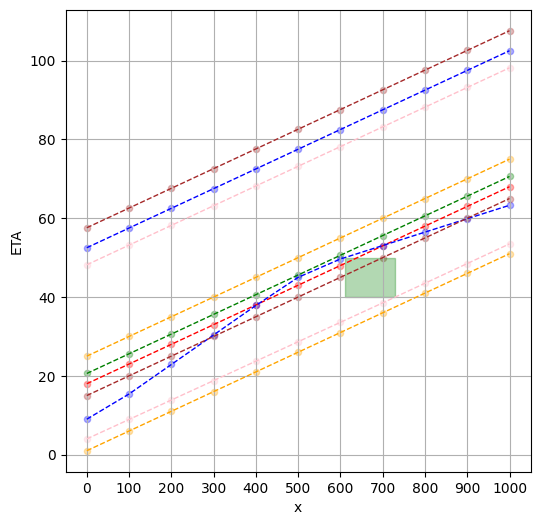

In [8]:
# print(simulation.reservation_table.eta_table[90:])
cars = simulation.CARS
print([car.itinerary[0]["eta"] for car in cars])# new_eta = [{'waypoint_idx': 0, 'x': 0.0, 'eta': 6.192323335817964, 'car_idx': 1}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 6.773999748762652, 'car_idx': 1}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 10.107333082095984, 'car_idx': 1}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 13.440666415429318, 'car_idx': 1}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 16.77399974876265, 'car_idx': 1}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 20.107333082095984, 'car_idx': 1}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 23.44066641542932, 'car_idx': 1}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 26.773999748762648, 'car_idx': 1}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 31.273999748762648, 'car_idx': 1}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 36.27399974876265, 'car_idx': 1}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 41.27399974876265, 'car_idx': 1}]
simulation.reservation_table.plot_with_noise(noise_list=[noise])

In [15]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images')
video_file = 'output_video_test.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

# ここから下はDebug用のセル

In [6]:
# Initialize
car_0 = CARS[0]
print(arrival_times)
car_0.arrival_time

[1.1514412675820007, 20.670029824891007, 21.993481994314482, 30.18365737679346, 35.091883812613865, 45.16063044492818, 46.75884290964873, 52.515749460062686, 52.90767092789682, 58.33068176234094]


1.1514412675820007

In [22]:
import xml.etree.ElementTree as ET
import gzip
import io
import xmltodict

def read_and_decompress(file_path):
    with open(file_path, 'rb') as file:
        file.read(18)  # 先頭の18バイトをスキップ
        compressed_data = file.read()  # 残りのデータを読み込む

    # gzipでデータを解凍
    try:
        with gzip.open(io.BytesIO(compressed_data), 'rb') as gz:
            decompressed_data = gz.read()
            return decompressed_data
    except gzip.BadGzipFile:
        return None  # 圧縮ファイルが壊れているか、正しくないフォーマット

def convert_xml_to_dict(xml_data):
    # XMLデータを辞書に変換
    dict_data = xmltodict.parse(xml_data)
    return dict_data

# ファイルパス
file_path = 'input.send'

# XMLデータを解凍して取得
decompressed_data = read_and_decompress(file_path)

if decompressed_data:
    # XMLデータのパースと内容の表示
    xml_dict = convert_xml_to_dict(decompressed_data)
    print(xml_dict)
else:
    print("Failed to decompress or read the file.")


{'Report': {'@xmlns': 'http://xml.kishou.go.jp/jmaxml1/', '@xmlns:jmx': 'http://xml.kishou.go.jp/jmaxml1/', '@xmlns:jmx_add': 'http://xml.kishou.go.jp/jmaxml1/addition1/', 'Control': {'Title': '気象警報・注意報（Ｈ２７）', 'DateTime': '2024-04-06T21:14:30Z', 'Status': '通常', 'EditorialOffice': '青森地方気象台', 'PublishingOffice': '青森地方気象台'}, 'Head': {'@xmlns': 'http://xml.kishou.go.jp/jmaxml1/informationBasis1/', 'Title': '青森県気象警報・注意報', 'ReportDateTime': '2024-04-07T06:14:00+09:00', 'TargetDateTime': '2024-04-07T06:14:00+09:00', 'EventID': None, 'InfoType': '発表', 'Serial': None, 'InfoKind': '気象警報・注意報', 'InfoKindVersion': '1.2_2', 'Headline': {'Text': '青森県では、８日まで空気の乾燥した状態が続くため、火の取り扱いに注意してください。津軽、三八上北では、ここしばらくなだれに注意してください。', 'Information': [{'@type': '気象警報・注意報（府県予報区等）', 'Item': {'Kind': [{'Name': '乾燥注意報', 'Code': '21'}, {'Name': 'なだれ注意報', 'Code': '22'}], 'Areas': {'@codeType': '気象情報／府県予報区・細分区域等', 'Area': {'Name': '青森県', 'Code': '020000'}}}}, {'@type': '気象警報・注意報（一次細分区域等）', 'Item': [{'Kind': [{'Name': '乾燥注意報'

In [20]:
print(decompressed_data)

b'<?xml version="1.0" encoding="UTF-8"?>\n<Report xmlns="http://xml.kishou.go.jp/jmaxml1/" xmlns:jmx="http://xml.kishou.go.jp/jmaxml1/" xmlns:jmx_add="http://xml.kishou.go.jp/jmaxml1/addition1/">\n<Control>\n<Title>\xe6\xb0\x97\xe8\xb1\xa1\xe8\xad\xa6\xe5\xa0\xb1\xe3\x83\xbb\xe6\xb3\xa8\xe6\x84\x8f\xe5\xa0\xb1\xef\xbc\x88\xef\xbc\xa8\xef\xbc\x92\xef\xbc\x97\xef\xbc\x89</Title>\n<DateTime>2024-04-06T21:14:30Z</DateTime>\n<Status>\xe9\x80\x9a\xe5\xb8\xb8</Status>\n<EditorialOffice>\xe9\x9d\x92\xe6\xa3\xae\xe5\x9c\xb0\xe6\x96\xb9\xe6\xb0\x97\xe8\xb1\xa1\xe5\x8f\xb0</EditorialOffice>\n<PublishingOffice>\xe9\x9d\x92\xe6\xa3\xae\xe5\x9c\xb0\xe6\x96\xb9\xe6\xb0\x97\xe8\xb1\xa1\xe5\x8f\xb0</PublishingOffice>\n</Control>\n<Head xmlns="http://xml.kishou.go.jp/jmaxml1/informationBasis1/">\n<Title>\xe9\x9d\x92\xe6\xa3\xae\xe7\x9c\x8c\xe6\xb0\x97\xe8\xb1\xa1\xe8\xad\xa6\xe5\xa0\xb1\xe3\x83\xbb\xe6\xb3\xa8\xe6\x84\x8f\xe5\xa0\xb1</Title>\n<ReportDateTime>2024-04-07T06:14:00+09:00</ReportDateTime>\n<

In [14]:
import gzip
import xmltodict

def decompress_and_load_xml(input_gz_filename, output_xml_filename):
    # gzipファイルを解凍して内容を読み込む
    with gzip.open(input_gz_filename, 'rb') as gzip_file:
        xml_data = gzip_file.read()

    # 読み込んだデータをXMLファイルとして保存
    with open(output_xml_filename, 'wb') as xml_file:
        xml_file.write(xml_data)

    # XMLファイルを辞書として読み込む
    with open(output_xml_filename, 'rb') as xml_file:
        dict_data = xmltodict.parse(xml_file.read())

    return dict_data

# スクリプトの実行例
input_gz = 'output_file.gz'
output_xml = 'output_file.xml'
xml_dict = decompress_and_load_xml(input_gz, output_xml)

# 辞書データの出力例
# print(xml_dict)


ExpatError: not well-formed (invalid token): line 1, column 0

In [16]:
file_path = 'input.send'
with open(file_path, 'rb') as file:
    data = file.read()  # ファイルの内容を全て読み込む
    byte_count = len(data)
print(byte_count)

3579


In [10]:
pip install xmltodict

  Obtaining dependency information for xmltodict from https://files.pythonhosted.org/packages/94/db/fd0326e331726f07ff7f40675cd86aa804bfd2e5016c727fa761c934990e/xmltodict-0.13.0-py2.py3-none-any.whl.metadata

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
